# 1 Load the dataset

In [21]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

tfm = transforms.ToTensor()  # Automatically convert 0–255 to a [0,1] float tensor
# trainset = datasets.MNIST(root="~/.data", train=True,  download=True, transform=tfm)
testset  = datasets.MNIST(root="~/.data", train=False, download=True, transform=tfm)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256)

In [22]:
# Load SDT PyTorch implementation
from SDT_pt import SDT

device = torch.device("cpu")

# 2 Load SDT weights

Two utility functions:
- save_checkpoint(path, extra=None): Save the model and optimizer states, hyperparameter metadata, and optional training info (e.g., epoch/best_acc)
- load_checkpoint_create(path, use_cuda=None): Recreate a model and optimizer from a checkpoint, returning (tree, optimizer, extra)

In [23]:
# Define save/load utilities
import os
from typing import Optional, Tuple

def save_checkpoint(path: str, tree, optimizer, extra: Optional[dict]=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    ckpt = {
        'model_state': tree.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'meta': {
            'input_dim': tree.input_dim,
            'output_dim': tree.output_dim,
            'depth': tree.depth,
            'lamda': tree.lamda,
            'inv_temp': tree.inv_temp,
            'hard_leaf_inference': tree.hard_leaf_inference,
        }
    }
    if extra is not None:
        ckpt['extra'] = extra
    torch.save(ckpt, path)
    print(f"Saved checkpoint to: {path}")


def load_checkpoint_create(path: str, use_cuda: Optional[bool]=None) -> Tuple[object, object, Optional[dict]]:
    use_cuda = torch.cuda.is_available() if use_cuda is None else use_cuda
    device = torch.device('cuda' if use_cuda else 'cpu')
    ckpt = torch.load(path, map_location=device)
    # Reconstruct the model (must use the same SDT class in this session)
    SDT_cls = SDT  # bound above via SDT
    meta = ckpt.get('meta', {})
    tree_new = SDT_cls(meta.get('input_dim', 28*28), meta.get('output_dim', 10),
                       depth=int(meta.get('depth', 5)), lamda=float(meta.get('lamda', 1e-3)),
                       use_cuda=use_cuda, inv_temp=float(meta.get('inv_temp', 1.0)),
                       hard_leaf_inference=bool(meta.get('hard_leaf_inference', False))).to(device)
    # Turn off strict mode to be compatible with older checkpoints (may include EMA buffer keys)
    missing, unexpected = tree_new.load_state_dict(ckpt['model_state'], strict=False)
    if missing or unexpected:
        print(f"load_state_dict warnings - missing: {list(missing)}, unexpected: {list(unexpected)}")
    optim_new = torch.optim.Adam(tree_new.parameters(), lr=1e-3, weight_decay=5e-4)
    if 'optimizer_state' in ckpt:
        optim_new.load_state_dict(ckpt['optimizer_state'])
        # Move optimizer state tensors to the current device
        for state in optim_new.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    print(f"Loaded checkpoint from: {path}")
    return tree_new, optim_new, ckpt.get('extra')

In [24]:
ckpt_path = "./checkpoints/sdt_mnist.pt"

# Recreate model and optimizer from the checkpoint and run a quick validation
use_cuda = (device.type == 'cuda')
tree, optimizer, extra = load_checkpoint_create(ckpt_path, use_cuda=use_cuda)
print('extra:', extra)

tree.eval()
with torch.no_grad():
    data, target = next(iter(testloader))
    data, target = data.to(device), target.to(device)
    logits = tree.forward(data)
    pred = logits.argmax(dim=1)
    acc = (pred == target).float().mean().item()
print(f"Reloaded model quick acc on a batch: {acc*100:.2f}%")
# Continue training: replace tree/optimizer with the loaded pair, then call train_and_eval

Loaded checkpoint from: ./checkpoints/sdt_mnist.pt
extra: {'note': 'after training'}
Reloaded model quick acc on a batch: 94.14%


# 2 Visualization

For SDT, each inner node learns a weight vector $W$ over the input features (same length as the input features) and a bias term $b$. By visualizing the internal-node $W$, we can understand the SDT's decision process—for example, which feature dimensions have higher weights and thus influence the decision more.

Additionally, leaf nodes, as the end of a decision path, learn the class probability distributions.

---

The notebook provides a `visualize_sdt` function to visualize the SDT's decision process on a particular sample. It plots the decision tree and returns a dictionary `info` with node parameters:
- depth: depth of the tree
- internal_nodes (node info): list[ {index, layer, W (Tensor), b (float)} ]
- leaves (leaf info): list[ {index, class_logits (Tensor), class_probs (Tensor)} ]

In [25]:
# ---- SDT visualization ----
import math

def extract_sdt_parameters(tree):
    """
    Extract parameter information of the whole tree for external access:
    - internal_nodes: list[ {index, layer, W (Tensor), b (float)} ]
    - leaves: list[ {index, class_logits (Tensor), class_probs (Tensor)} ]
    Note: W corresponds to the weight vector excluding the constant 1 used in data augmentation; b comes from column 0 of inner_nodes.weight.
    """
    tree.eval()
    with torch.no_grad():
        D = tree.depth
        Ni = tree.internal_node_num_
        L = tree.leaf_node_num_
        C = tree.output_dim

        # internal nodes: inner_nodes.weight shape (Ni, input_dim+1)
        W_full = tree.inner_nodes.weight.detach().cpu()  # [Ni, in_dim+1]
        internals = []
        for i in range(Ni):
            wrow = W_full[i]
            b = float(wrow[0].item())
            W = wrow[1:].clone()  # remove the constant term weight
            layer = int(math.floor(math.log2(i + 1)))
            internals.append({
                'index': i,
                'layer': layer,
                'W': W,
                'b': b,
            })

        # leaves: leaf_nodes.weight shape (C, L) -> for leaf l, column weight[:, l] is class logits
        W_leaf = tree.leaf_nodes.weight.detach().cpu()  # [C, L]
        leaves = []
        for l in range(L):
            logits = W_leaf[:, l]
            probs = torch.softmax(logits, dim=0)
            leaves.append({
                'index': l,
                'class_logits': logits,
                'class_probs': probs,
            })

    return {
        'depth': D,
        'internal_nodes': internals,
        'leaves': leaves,
    }


def _binary_tree_positions(depth, x_span=(0.0, 1.0), y_step=1.0):
    """
    Generate node coordinates for a full binary tree.
    Returns:
      - pos_internal: dict[i] -> (x, y) for i in [0, Ni)
      - pos_leaf: dict[l] -> (x, y) for l in [0, L)
    Nodes are arranged level-wise, y decreases downward.
    """
    Ni = 2 ** depth - 1
    L = 2 ** depth
    pos_internal = {}
    pos_leaf = {}

    # y coordinate for each layer
    def layer_y(layer):
        return -layer * y_step

    # compute internal node positions (even spacing within each layer)
    start = 0
    for layer in range(depth):
        count = 2 ** layer
        xs = np.linspace(x_span[0], x_span[1], count + 2)[1:-1]  # remove endpoints, keep middle points
        for j in range(count):
            idx = start + j
            pos_internal[idx] = (float(xs[j]), layer_y(layer))
        start += count

    # leaves at the last layer: evenly spaced
    xs_leaf = np.linspace(x_span[0], x_span[1], L + 2)[1:-1]
    for l in range(L):
        pos_leaf[l] = (float(xs_leaf[l]), layer_y(depth))

    return pos_internal, pos_leaf


essential_colors = {
    'internal_node': '#1f77b4',  # blue
    'leaf_node': '#ff7f0e',      # orange
    'edge': '#888888',           # default edge
    'best_edge': '#2ca02c',      # green
}


def _best_path_for_sample(tree, x_single):
    """Given a single sample, return best path information.
    Output:
      - path_internal: list of internal node indices (from root to the last internal node)
      - lr_choices: list of 0/1, 0 means left, 1 means right
      - best_leaf: leaf index
    """
    tree.eval()
    D = tree.depth
    Ni = tree.internal_node_num_

    with torch.no_grad():
        # Prepare input and reuse the model's internal computations
        device = next(tree.parameters()).device
        x = x_single.to(device)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)  # [1, 784]
        # Data augmentation consistent with the model (prepend constant 1)
        bias = torch.ones(x.size(0), 1, device=device, dtype=x.dtype)
        x_aug = torch.cat((bias, x), dim=1)

        logits_internal = tree.inner_nodes(x_aug)  # [1, Ni]
        path_prob = torch.sigmoid(tree.inv_temp * logits_internal)  # [1, Ni]

        # Traverse the tree, choosing the side with higher probability at each level
        path_internal = []
        lr_choices = []
        lr_probs = []  # record the probability of choosing left at each level
        curr_idx = 0  # root
        for layer in range(D):
            if layer == D:  # never triggered; guard
                break
            if curr_idx >= Ni:
                break
            path_internal.append(curr_idx)
            p = path_prob[0, curr_idx].item()
            # left prob is p, right prob is 1-p
            go_right = 1 if (1.0 - p) > p else 0
            lr_choices.append(go_right)
            lr_probs.append(p)  # record left prob
            # move to next internal node index if any
            left_child = 2 * curr_idx + 1
            right_child = 2 * curr_idx + 2
            curr_idx = right_child if go_right == 1 else left_child
            # if next step goes beyond internal nodes, break and go to leaf
            if curr_idx >= Ni:
                break

        # compute leaf index when reaching the last internal layer
        last_layer_start = 2 ** (D - 1) - 1
        idx_in_last_layer = path_internal[-1] - last_layer_start
        last_choice = lr_choices[-1] if lr_choices else 0
        best_leaf = 2 * idx_in_last_layer + last_choice

    return path_internal, lr_choices, best_leaf, lr_probs


def visualize_sdt(tree, x_single, figsize=(10, 6), title=None):
    """
    Visualize the entire SDT:
    Requirement: tree.hard_leaf_inference must be True.
    - Draw all nodes and edges;
    - Highlight the best path (relative to the given sample) in green;
    - Annotate left/right probability at internal nodes along the best path (from lr_probs in _best_path_for_sample);
    - Return (fig, ax, info), where info is the result of extract_sdt_parameters(tree).
    """
    if not getattr(tree, 'hard_leaf_inference', False):
        raise ValueError('hard_leaf_inference 必须为 True 才能进行该可视化。请在构造 SDT 时设置 hard_leaf_inference=True。')

    D = tree.depth
    Ni = tree.internal_node_num_

    info = extract_sdt_parameters(tree)
    pos_int, pos_leaf = _binary_tree_positions(D)

    # compute the best path for the single sample (including left probability at each node)
    path_internal, lr_choices, best_leaf, lr_probs = _best_path_for_sample(tree, x_single)
    on_path = set(path_internal)
    left_prob_by_idx = {path_internal[k]: lr_probs[k] for k in range(len(path_internal))}

    best_edges = set()
    # build the set of edges to highlight (internal -> internal or internal -> leaf)
    for k, i in enumerate(path_internal):
        left = 2 * i + 1
        right = 2 * i + 2
        choose_right = (lr_choices[k] == 1) if k < len(lr_choices) else False
        child = right if choose_right else left
        if child < Ni:
            best_edges.add((i, child))
        else:
            # map to leaf
            last_start = 2 ** (D - 1) - 1
            idx_in_last = i - last_start
            l_left = 2 * idx_in_last
            l_right = l_left + 1
            leaf_child = l_right if choose_right else l_left
            best_edges.add((i, Ni + leaf_child))  # use Ni offset to include leaves in the same id space

    # draw
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()

    # draw edges (all)
    for i in range(Ni):
        xi, yi = pos_int[i]
        left = 2 * i + 1
        right = 2 * i + 2
        # left edge
        if left < Ni:
            xj, yj = pos_int[left]
            col = essential_colors['best_edge'] if (i, left) in best_edges else essential_colors['edge']
            ax.plot([xi, xj], [yi, yj], color=col, linewidth=2 if col == essential_colors['best_edge'] else 1)
        else:
            # connect to leaf
            last_start = 2 ** (D - 1) - 1
            idx_in_last = i - last_start
            l_left = 2 * idx_in_last
            xj, yj = pos_leaf[l_left]
            col = essential_colors['best_edge'] if (i, Ni + l_left) in best_edges else essential_colors['edge']
            ax.plot([xi, xj], [yi, yj], color=col, linewidth=2 if col == essential_colors['best_edge'] else 1)
        # right edge
        if right < Ni:
            xj, yj = pos_int[right]
            col = essential_colors['best_edge'] if (i, right) in best_edges else essential_colors['edge']
            ax.plot([xi, xj], [yi, yj], color=col, linewidth=2 if col == essential_colors['best_edge'] else 1)
        else:
            last_start = 2 ** (D - 1) - 1
            idx_in_last = i - last_start
            l_right = 2 * idx_in_last + 1
            xj, yj = pos_leaf[l_right]
            col = essential_colors['best_edge'] if (i, Ni + l_right) in best_edges else essential_colors['edge']
            ax.plot([xi, xj], [yi, yj], color=col, linewidth=2 if col == essential_colors['best_edge'] else 1)

    # draw internal nodes + annotations
    for i in range(Ni):
        xi, yi = pos_int[i]
        ax.scatter([xi], [yi], s=200, marker='o', color=essential_colors['internal_node'], edgecolors='black', zorder=3)
        # node id
        ax.text(xi+0.025, yi, f"IN {i}", ha='center', va='bottom', fontsize=9)
        # annotate left/right prob if on best path
        if i in on_path:
            p_left = float(left_prob_by_idx.get(i, 0.0))
            p_right = 1.0 - p_left
            ax.text(xi, yi-0.2, f"L:{p_left:.2f} R:{p_right:.2f}", color=essential_colors['best_edge'],
                    ha='center', va='bottom', fontsize=8)

    # draw leaves
    L = 2 ** D
    for l in range(L):
        xj, yj = pos_leaf[l]
        ax.scatter([xj], [yj], s=180, marker='s', color=essential_colors['leaf_node'], edgecolors='black', zorder=3)
        # annotate leaf top-1 class
        leaf_logits = info['leaves'][l]['class_logits']
        top1 = int(torch.argmax(leaf_logits).item())
        ax.text(xj, yj-0.1, f"L {l}\nC {top1}", ha='center', va='top', fontsize=7)

    if title is None:
        title = f"Soft Decision Tree (depth={D}) | best leaf={best_leaf}"
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax, info

## (1) Take one sample and visualize the decision tree with its best path

Label: 1


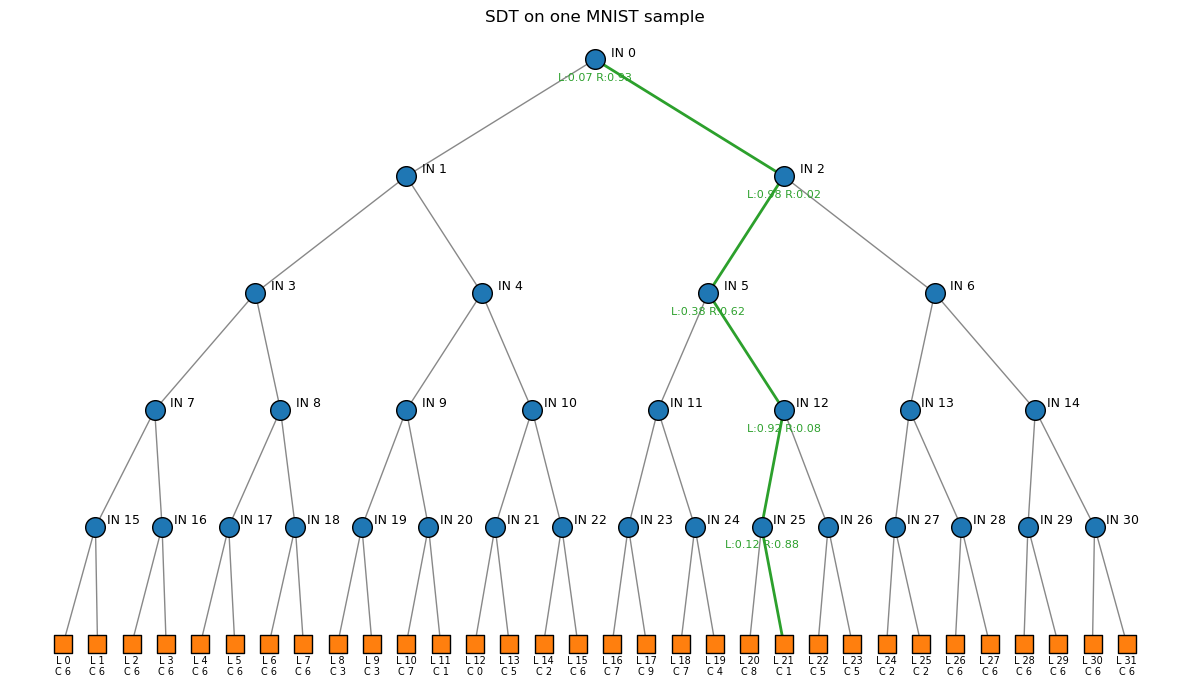

Internal node 0: layer= 0  b= -0.37543225288391113  W-norm= 5.183743000030518
Leaf 0 probs (top-3): torch.return_types.topk(
values=tensor([0.1003, 0.1003, 0.1003]),
indices=tensor([6, 1, 5]))


In [31]:
# Example: take one sample and visualize the best path
# Note: ensure tree.hard_leaf_inference == True

data_batch, target_batch = next(iter(testloader))
n = 96
sample = data_batch[n]  # take one sample, shape [1, 1, 28, 28]

print(f"Label: {target_batch[n].item()}")  # print the ground-truth label

fig, ax, info = visualize_sdt(tree, sample, figsize=(12, 7), title="SDT on one MNIST sample")
plt.show()

# Access node information examples:
# - W and b of the 0-th internal node
node0 = info['internal_nodes'][0]
print('Internal node 0: layer=', node0['layer'], ' b=', node0['b'], ' W-norm=', node0['W'].norm().item())
# - Class probability distribution of the 0-th leaf
leaf0 = info['leaves'][0]
print('Leaf 0 probs (top-3):', torch.topk(leaf0['class_probs'], k=3))

## (2) Visualize all internal nodes' weights W

The function visualize_internal_node_weight visualizes the weight W of an internal node, either as a heatmap or as a heatvector.

In [27]:
# ---- Internal node weight visualization utilities ----

def visualize_internal_node_weight(W, b=None,
                                   mode='heatmap',
                                   image_shape=None,
                                   cmap='gray',
                                   normalize=True,
                                   show_colorbar=True,
                                   figsize=(4, 4),
                                   title=None,
                                   ax=None):
    """
    Visualize an internal node's weight vector W (and optional bias b).
    Args:
      - W: 1D vector (torch.Tensor or numpy.ndarray), length = input dimension
      - b: optional bias (float), will be shown in the title if provided
      - mode: 'heatmap' or 'heatvector'
          * heatmap: requires image_shape=(H, W), reshape the vector to HxW heatmap
          * heatvector: show the vector as a 1xN heatmap
      - image_shape: tuple (H, W). Required when mode='heatmap';
                     if not provided, will attempt to infer sqrt(N) x sqrt(N) if possible, otherwise raise.
      - cmap: colormap, default 'gray' (grayscale), or pass 'viridis', etc.
      - normalize: whether to set vmin/vmax from current weight range for local contrast
      - show_colorbar: whether to show colorbar
      - figsize: figure size
      - title: title; by default it will include mode and b if provided
      - ax: optional Matplotlib Axes; if not provided, a new figure will be created
    Returns: (fig, ax)
    """
    # convert to numpy vector
    if isinstance(W, torch.Tensor):
        w = W.detach().cpu().float().numpy()
    else:
        w = np.asarray(W, dtype=np.float32)

    N = w.size
    # infer/validate shape
    if mode == 'heatmap':
        if image_shape is None:
            r = int(np.sqrt(N))
            if r * r == N:
                image_shape = (r, r)
            else:
                raise ValueError(f"heatmap 需要 image_shape，但 len(W)={N} 不是完美平方，无法自动推断。")
        H, Ww = int(image_shape[0]), int(image_shape[1])
        if H * Ww != N:
            raise ValueError(f"image_shape={image_shape} 与 len(weight)={N} 不匹配。")
        img = w.reshape(H, Ww)
    elif mode == 'heatvector':
        img = w.reshape(1, N)  # 1 x N heatvector visualization
    else:
        raise ValueError("mode 必须为 'heatmap' 或 'heatvector'")

    # normalization range
    vmin = vmax = None
    if normalize:
        wmin, wmax = np.min(w), np.max(w)
        if wmax > wmin:
            vmin, vmax = wmin, wmax
        # if constant, leave vmin/vmax unset and let imshow handle it

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    im = ax.imshow(img, cmap=cmap, aspect='auto' if mode == 'heatvector' else 'equal',
                   interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])

    if title is None:
        if b is not None:
            title = f"{mode} | b={b:.4f}"
        else:
            title = f"{mode}"
    ax.set_title(title)

    if show_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if created_fig:
        plt.tight_layout()
    return fig, ax

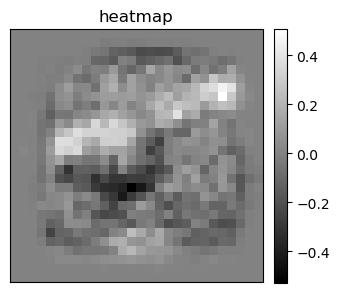

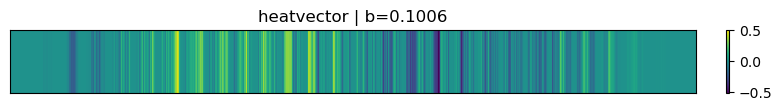

In [28]:
# Example: visualize one internal node's W (heatmap and heatvector)
# Requires having run extract_sdt_parameters/visualize_sdt above to obtain info
node_idx = 10
node = info['internal_nodes'][node_idx]
W_vec = node['W']
bias = node['b']

# Method 1: heatmap (visualize as 28x28, grayscale)
fig1, ax1 = visualize_internal_node_weight(W_vec, mode='heatmap', image_shape=(28, 28), cmap='gray', figsize=(3.5, 3.5))
plt.show()

# Method 2: heatvector (horizontal heat vector, use another colormap such as viridis)
fig2, ax2 = visualize_internal_node_weight(W_vec, b=bias, mode='heatvector', cmap='viridis', figsize=(8, 1.2))
plt.show()

## (3) Plot heatmaps of multiple internal nodes and class distributions of multiple leaves

In [29]:
# ---- Batch visualization: internal node heatmap grid + leaf distributions ----

def select_representative_internal_nodes(info, k=8, per_layer=False):
    """
    Select representative internal node indices.
    Strategy: sort by ||W|| L2 norm descending;
    - per_layer=True: pick ceil(k/Depth) per layer until k is reached.
    Returns: list[int]
    """
    internals = info['internal_nodes']
    depth = info['depth']

    # compute scores
    scored = []  # (score, idx, layer)
    for i, node in enumerate(internals):
        W = node['W']
        score = float(W.norm().item()) if isinstance(W, torch.Tensor) else float(np.linalg.norm(W))
        scored.append((score, i, node['layer']))

    if not per_layer:
        scored.sort(key=lambda t: t[0], reverse=True)
        return [i for _, i, _ in scored[:k]]

    # layer-wise selection
    per = math.ceil(k / depth)
    by_layer = {}
    for s, idx, layer in scored:
        by_layer.setdefault(layer, []).append((s, idx))
    for layer in by_layer:
        by_layer[layer].sort(key=lambda t: t[0], reverse=True)

    out = []
    for layer in range(depth):
        if layer not in by_layer:
            continue
        take = min(per, len(by_layer[layer]))
        out.extend([idx for _, idx in by_layer[layer][:take]])
        if len(out) >= k:
            break
    return out[:k]


def visualize_internal_nodes_grid(info, node_indices, image_shape=(28, 28),
                                  ncols=4, cmap='gray', normalize=True,
                                  figsize_per=(3.0, 3.0), suptitle=None):
    """
    Display multiple internal nodes' weights as a heatmap grid.
    Args:
      - info: output of extract_sdt_parameters
      - node_indices: list[int] indices of internal nodes to visualize
      - image_shape: (H, W) to reshape W into an image
      - ncols: number of columns per row
      - cmap/normalize/figsize_per: passed to single heatmap visualization
      - suptitle: figure title
    """
    nodes = info['internal_nodes']
    n = len(node_indices)
    ncols = max(1, int(ncols))
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per[0]*ncols, figsize_per[1]*nrows))
    axes = np.atleast_2d(axes)

    for k_idx, idx in enumerate(node_indices):
        r, c = divmod(k_idx, ncols)
        ax = axes[r, c]
        node = nodes[idx]
        W_vec = node['W']
        b = node['b']
        # reuse the single-image visualization function
        visualize_internal_node_weight(W_vec, b=b, mode='heatmap', image_shape=image_shape,
                                       cmap=cmap, normalize=normalize, show_colorbar=False,
                                       figsize=(1, 1), ax=ax,
                                       title=f"IN {idx} | Layer {node['layer']}")
    # clear unused subplots
    for k_idx in range(n, nrows*ncols):
        r, c = divmod(k_idx, ncols)
        axes[r, c].axis('off')

    if suptitle is None:
        suptitle = f"Internal nodes heatmaps (n={n})"
    fig.suptitle(suptitle)
    plt.tight_layout()
    return fig, axes


def select_representative_leaves_by_entropy(info, k=6, ascending=True):
    """
    Select representative leaf indices.
    Strategy: sort by entropy (ascending=True prioritizes lower-entropy, more "certain" leaves).
    Returns: list[int]
    """
    leaves = info['leaves']
    scored = []  # (entropy, idx)
    for l, leaf in enumerate(leaves):
        p = leaf['class_probs']
        if isinstance(p, torch.Tensor):
            p = p.detach().cpu().float().clamp_min(1e-12).numpy()
        else:
            p = np.asarray(p, dtype=np.float32)
            p = np.clip(p, 1e-12, 1.0)
        ent = float(-(p * np.log(p)).sum())
        scored.append((ent, l))
    scored.sort(key=lambda t: t[0], reverse=ascending)
    return [l for _, l in scored[:k]]


def visualize_leaf_distributions(info, leaf_indices, ncols=3, figsize_per=(3.2, 2.6),
                                 suptitle=None, ylim=(0, 1), annotate_top1=True):
    """
    Batch-visualize leaf nodes' class probability distributions (bar charts).
    Args:
      - info: output of extract_sdt_parameters
      - leaf_indices: list[int] leaf indices to visualize
      - ncols: number of columns per row
      - figsize_per: (w, h) for each subplot
      - suptitle: figure title
      - ylim: y-axis limits, default (0, 1)
      - annotate_top1: whether to annotate the top-1 class
    """
    leaves = info['leaves']
    n = len(leaf_indices)
    ncols = max(1, int(ncols))
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per[0]*ncols, figsize_per[1]*nrows))
    axes = np.atleast_2d(axes)

    classes = list(range(leaves[0]['class_probs'].numel())) if isinstance(leaves[0]['class_probs'], torch.Tensor) else list(range(len(leaves[0]['class_probs'])))

    for k_idx, lidx in enumerate(leaf_indices):
        r, c = divmod(k_idx, ncols)
        ax = axes[r, c]
        probs = leaves[lidx]['class_probs']
        if isinstance(probs, torch.Tensor):
            probs = probs.detach().cpu().numpy()
        ax.bar(classes, probs, color='#1f77b4')
        ax.set_xticks(classes)
        ax.set_ylim(*ylim)
        ax.set_title(f"Leaf {lidx} | top class={int(np.argmax(probs))}")
        if annotate_top1:
            t1 = int(np.argmax(probs))
            ax.text(t1, probs[t1]+0.02, f"{probs[t1]:.2f}", ha='center', va='bottom', fontsize=8)

    # clear unused subplots
    for k_idx in range(n, nrows*ncols):
        r, c = divmod(k_idx, ncols)
        axes[r, c].axis('off')

    if suptitle is None:
        suptitle = f"Leaf class distributions (n={n})"
    fig.suptitle(suptitle)
    plt.tight_layout()
    return fig, axes

Representative internal nodes: [0, 1, 2, 10, 14, 18, 22, 26]


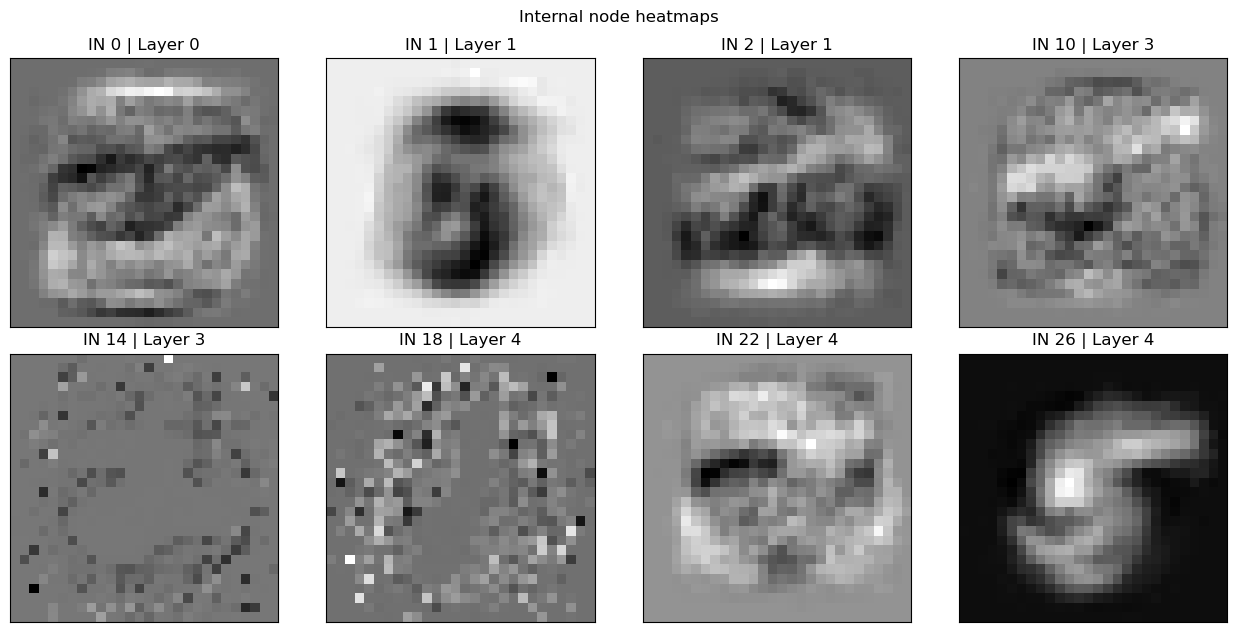

Representative leaves: [2, 5, 7, 12, 21, 31]


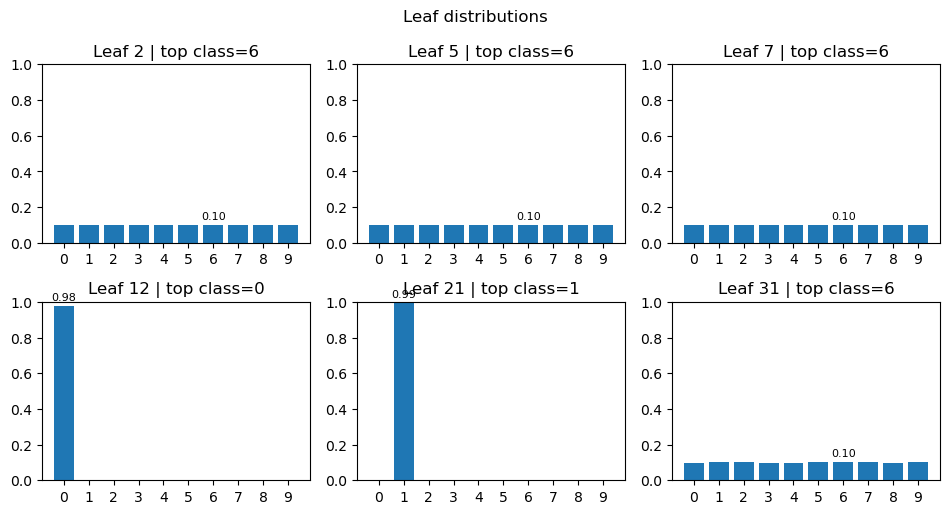

In [30]:
# Example: select representative internal nodes and leaves, and visualize them in batch
# Ensure you have obtained info by visualizing the tree (or call extract_sdt_parameters directly)

# 1) Representative internal nodes: pick top 8 by ||W|| (set per_layer=True to balance across layers)
# rep_nodes = select_representative_internal_nodes(info, k=8, per_layer=False)
rep_nodes = [0, 1, 2, 10, 14, 18, 22, 26]  # manually specify some indices
print('Representative internal nodes:', rep_nodes)
_ = visualize_internal_nodes_grid(info, rep_nodes, image_shape=(28, 28), ncols=4, cmap='gray',
                                  normalize=True, figsize_per=(3.2, 3.2), suptitle='Internal node heatmaps')
plt.show()

# 2) Representative leaves: choose 6 with lowest entropy (more "certain")
# rep_leaves = select_representative_leaves_by_entropy(info, k=6, ascending=True)
rep_leaves = [2, 5, 7, 12, 21, 31]  # manually specify some leaf indices
print('Representative leaves:', rep_leaves)
_ = visualize_leaf_distributions(info, rep_leaves, ncols=3, figsize_per=(3.2, 2.6), suptitle='Leaf distributions')
plt.show()